In [3]:
# !uv sync
%load_ext autoreload
%autoreload 2

In [3]:
import pathlib
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from cartopy import crs as ccrs  # for map projection
from cartopy import feature as cfeature

import lst_filler as lf
from lst_filler.spatial import calculate_res_metres

In [5]:
pd.set_option('display.max_columns', None)

In [4]:
# YAML based config file for consistent data loading
config = lf.load_yaml_config('../data/lst_config.yaml')

# have a look at the config here
pprint.pprint(config.toDict())

# reason for using the config file is that it's much easier to change things. 
# Learning to program this way will be useful down the line.

{'bbox_WSEN': [17.89601, -34.48499, 19.598891, -33.159334],
 'dem_cop90': {'metadata': {'doi': 'https://doi.org/10.5069/G9028PQB',
                            'source': 'https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-90'},
               'search': {'bbox': [17.89601, -34.48499, 19.598891, -33.159334],
                          'collections': ['cop-dem-glo-90']},
               'stackstac': {'assets': ['data'],
                             'bounds_latlon': [17.89601,
                                               -34.48499,
                                               19.598891,
                                               -33.159334],
                             'epsg': 22234,
                             'resolution': 1000}},
 'modis_lst': {'metadata': {'doi': 'https://doi.org/10.5067/MODIS/MYD11A1.061',
                            'source': 'https://planetarycomputer.microsoft.com/dataset/modis-11A1-061'},
               'search': {'bbox': [17.89601, -34.48499, 19.5

# Download MODIS data

In [5]:
### MODIS LST downloading ###

# we can iterate through the months to fetch modis data
# and after that iterate through these data for matchups
for t0 in pd.date_range('2015-01-01', '2024-03-31', freq='MS'):
    t1 = t0 + pd.DateOffset(months=1, seconds=-1)
    sname = f'../data/modis/modis_lst-cape_town_area-{t0:%Y_%m}.nc'
    if pathlib.Path(sname).exists():
        continue
    
    # fetch MODIS data - see the functions in data.modis for more details
    modis_lst = lf.data.modis.get_modis_lst(
        f"{t0:%Y-%m-%d}/{t1:%Y-%m-%d}",
        config.modis_lst,
        max_view_angle=40,  # angle must be < 40 degrees (not the -65 offset on the original view angel)
    )

    (  # prepare data for writing
        modis_lst
        .rename('modis_LST')
        # we have to drop some of the unwritable metadata
        .pipe(lf.utils.make_dataset_metadata_writable)
        .to_netcdf(  # save the data to disk
            sname,
            encoding={k: {'zlib': True} for k in ['modis_LST']},
            engine='h5netcdf')
    )

    

# Load station data (df)

In [6]:
# for this to work, you need to extract the parquet station files to
# the path defined in the config file above (config['stations']['path])
df = lf.data.stations.read_stations(**config.stations, progressbar=True)

# purely for visualization
m = lf.data.stations.convert_to_geopandas(df, aggregate=True).explore(
    tiles='cartodbpositron',
    marker_kwds=dict(radius=10), 
    color='red')

[########################################] | 100% Completed | 525.75 ms


In [43]:
df = pd.read_parquet('../data/regression_station_data.parquet')

In [44]:
df.shape

(208686, 18)

In [45]:
df.head()

,datetime,station_name,latitude,longitude,temperature,dew_point_temperature,station_level_pressure,precipitation,wind_direction,wind_speed,wind_gust,temperature_quality_code,dew_point_temperature_quality_code,station_level_pressure_quality_code,wind_direction_quality_code,wind_speed_quality_code,wind_gust_quality_code,LST
0,2016-01-01 00:00:00,GEELBEK,-33.183,18.117,14.8,14.1,1013.7,0.0,230.0,1.5,0.0,1,1,1,1,1,0.0,290.004190
1,2016-01-01 00:00:00,MALMESBURY,-33.467,18.717,20.2,18.0,1001.0,0.0,240.0,1.0,0.0,1,1,NE,1,1,0.0,300.202415
2,2016-01-01 00:00:00,ROBBEN ISLAND,-33.800,18.367,18.0,16.1,1012.8,0.0,310.0,2.1,0.0,1,1,1,1,1,0.0,295.827688
3,2016-01-01 00:00:00,WORCESTER,-33.617,19.467,23.6,19.2,991.0,0.0,100.0,1.0,0.0,1.0,1.0,1,1,1,0.0,304.521368
4,2016-01-01 03:00:00,GEELBEK,-33.183,18.117,15.4,14.9,1013.2,0.0,250.0,1.0,0.0,1,1,1,1,1,0.0,290.820939


In [10]:
df = df.set_index(['datetime', 'station_name']).sort_index()

# Loading MODIS data

In [7]:
da_modis = xr.open_mfdataset('../data/modis/*.nc', parallel=True).modis_LST.sel(time=slice('2016', None))

In [12]:
t0, t1 = da_modis.time.min().values, da_modis.time.max().values

# now we select a subset of the data that matches with our MODIS data
df_sorted = (
    df
    .loc[slice(t0, t1)]  # select the time range that matches with MODIS data
    .reorder_levels([1, 0])  # reorder levels [time, station] -> [station, time]
    .sort_index()  # sort by station^time
)

In [20]:
df_sorted.shape

(186514, 16)

# Matchups 

In [21]:
with open("../data/matchup/matchup_station_modis_lst_README.md", mode='w') as f:
    f.write(lf.data.matchup.README)

df_matched = df_sorted.groupby('station_name').apply(
    lambda x: lf.data.matchup.match_station_with_modis(x, da_modis))
df_matched.to_parquet('../data/matchup/regression_matchup_station_modis_lst.parquet')

In [13]:
df_matched = pd.read_parquet('../data/matchup/regression_matchup_station_modis_lst.parquet')

____

For the sake of pragmatism, we will use only the immediate time step for the linear regression instead of t and (t-1) from the station - this should give us more points.  
We will have to drop the stations that we don't have linear regression coefficients for.

In this section, we will:

1. convert the station LST (converted from station data using the linear regression) to the MODIS grid. 
2. merge the station data with the MODIS data
3. add the spatial information such as the elevation and maybe slope

### Part 1: convert stations to MODIS grid

In [8]:
da_grid = da_modis.mean(['time', 'band']) * np.nan  # make nan, only a dummy array

In [56]:
df_sorted.columns

Index(['latitude', 'longitude', 'temperature', 'dew_point_temperature',
       'station_level_pressure', 'precipitation', 'wind_direction',
       'wind_speed', 'wind_gust', 'temperature_quality_code',
       'dew_point_temperature_quality_code',
       'station_level_pressure_quality_code', 'wind_direction_quality_code',
       'wind_speed_quality_code', 'wind_gust_quality_code', 'LST'],
      dtype='object')

In [ ]:
da_station_lst = (
    df_sorted
    .reset_index()  # moving station name and datetime to columns
    .where(lambda x: (x.datetime.dt.hour - 10).abs() <= 1)  # filter out values that don't match modis time (i.e., 9 - 10 AM)
    .dropna()  # everything that doesn't match is NaN, so we can drop it
    .set_index(['datetime', 'latitude', 'longitude'])  # set the index to datetime, latitude and longitude  
    .loc[:, ['LST']]  
    .to_xarray()  
    .rename(  # renaming these to the same coordinates as MODIS LST - need this for reindexing
        LST='station_LST',
        latitude='y',
        longitude='x',
        datetime='time')
    .station_LST  # select the temperature variable so we have a xr.DataArray
    .reindex_like(
        other=da_grid,  # this is the modis grid (but an empty dummy array)
        method='nearest',  # select the nearest grid point from the MODIS data
        tolerance=0.005,  # but only if it's within 0.01 degrees (which is the MODIS resolution)
    )
)

In [16]:
resolution = calculate_res_metres(da_modis)

c:\Users\Benedict\python_folder\AIMS_Masters\lst_filler\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


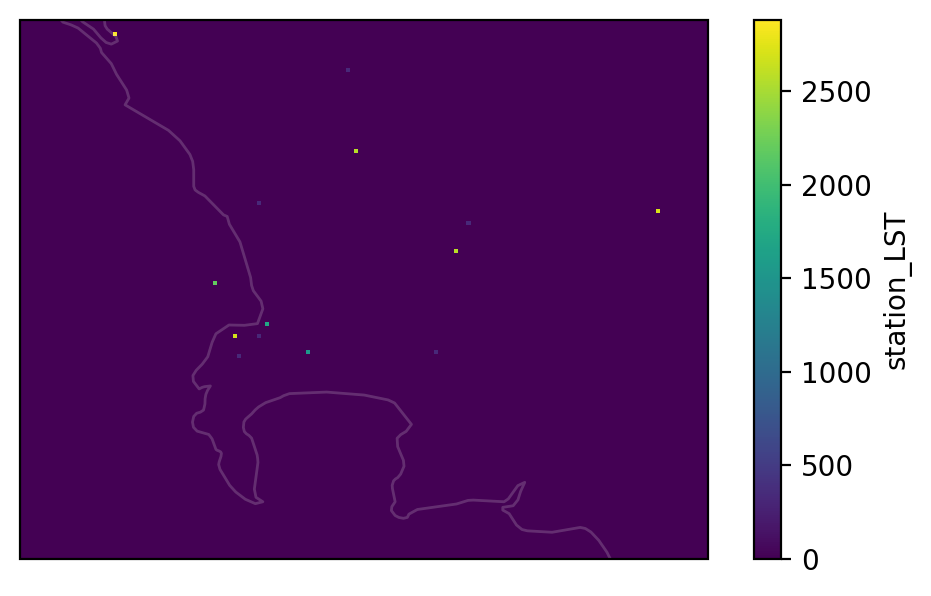

In [25]:
fig, ax = plt.subplots(figsize=(6, 3.5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200)
da_station_lst.count(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='0.9', alpha=0.2)

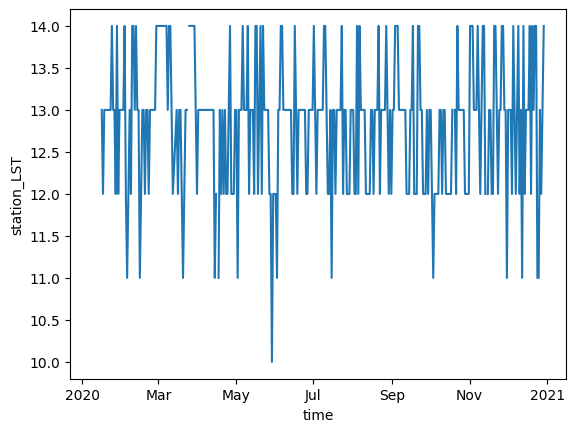

In [17]:
da_station_lst.count(dim=['x', 'y']).where(lambda x: x>= 10).plot();

### Part 2: combine the modis and station data

In [18]:
def convert_time_to_daily(da):
    """Makes sure that the data is only indexed on the day
    
    We cover a "worst case scenario" where there might be more than one observation 
    per day. This should not be the case in 99.9% of the cases, but we need to be careful.
    
    """
    time_day = xr.DataArray(da.time.values.astype('datetime64[D]'), dims=['time'], coords={'time': da.time})
    da = da.groupby(time_day).mean(dim='time').rename(group='time')
    return da

In [54]:
da_station_lst

<xarray.DataArray 'station_LST' (time: 3838, y: 134, x: 171)> Size: 704MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(3838, 134, 171))
Coordinates:
  * time     (time) datetime64[ns] 31kB 2016-01-02T09:00:00 ... 2024-03-17T09...
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59

In [ ]:
from tqdm.dask import TqdmCallback as ProgressBar

with ProgressBar():
    da_lst = xr.concat([ 
        # when we concatenate the data, we need to make sure that time is the same
        # for the two datasets when they overlap in time
        da_station_lst.pipe(convert_time_to_daily), 
        da_modis.isel(band=0, drop=True).pipe(convert_time_to_daily),
        ], dim='dataset')
    
da_lst = (
    da_lst
    .assign_coords(dataset=['station', 'modis'])  # assign the dataset names
    .rename('lst')  # rename the variable to lst
    # .mean(dim='dataset')  # average over the two datasets
    .chunk({'x': 80, 'y':80, 'time': 31})  # make it more efficient for dask
    .persist()  # load data into memory, but keep it in dask
)

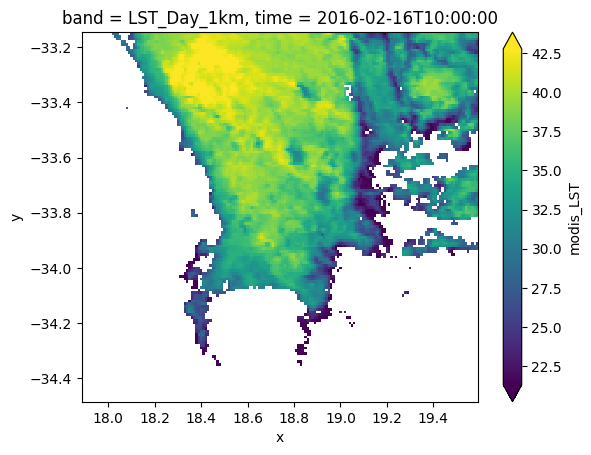

In [25]:
da_modis.sel(time="2016-02-16 10:00:00").isel(band=0).pipe(lambda x:x-273.15).plot(robust=True)

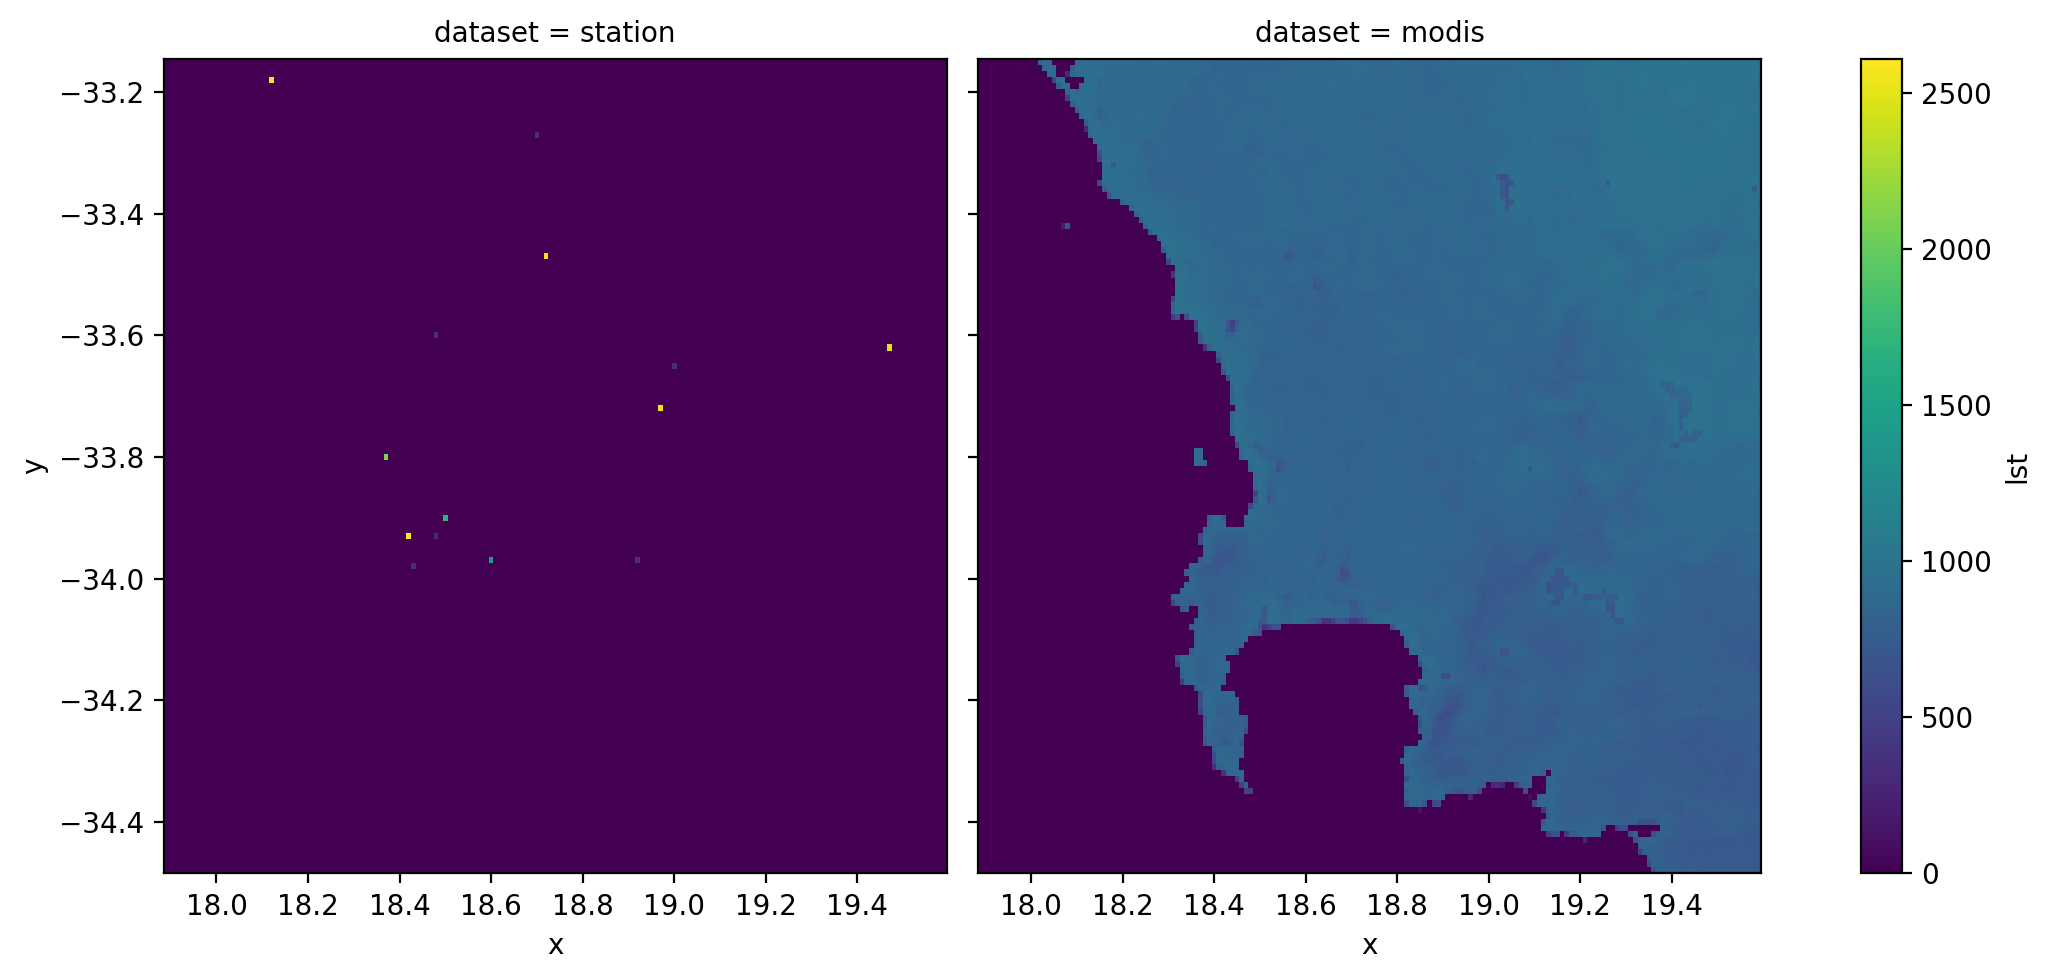

In [33]:
fg = da_lst.count('time').plot(col='dataset', col_wrap=2, size=5)
fg.fig.set_dpi(200)

### Part 3: Getting additional data for regression

In [1]:
from lst_filler.data.other import get_dem

In [9]:
dem = get_dem(
    config.dem_cop90.search, 
    config.dem_cop90.stackstac,
    da_grid,
)

In [13]:
def drop_coords_without_dim(da):
    """
    Drop coordinates that do not have a corresponding dimension.

    Parameters
    ----------
    da : xarray.DataArray
        The input data array.

    Returns
    -------
    xarray.DataArray
        The data array with dropped coordinates.
    """
    for c in da.coords:
        if c not in da.dims:
            da = da.drop_vars(c)
    return da

In [15]:
drop_coords_without_dim(dem).to_netcdf("elev_slope.nc")

In [ ]:
dem.to_netcdf("elev_slope.nc")

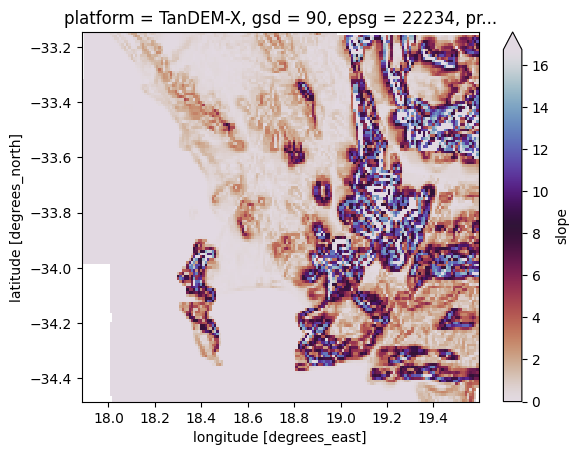

In [22]:
dem.slope.plot(robust=True, cmap='twilight_r', vmin=0)

### Part 4

In [59]:
x_varnames = ['elev', 'slope', 'aspect_cos', 'aspect_sin']
ds_1 = dem[x_varnames].to_array(dim="dataset")
ds_1 = ds_1.drop_vars(["platform", "gsd", "epsg", "proj:code", "proj:shape", "spatial_ref"])
ds_1

<xarray.DataArray (dataset: 4, y: 134, x: 171)> Size: 733kB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.10380591e+03,  1.13757544e+03,  1.18955127e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.12288574e+03,  1.18680859e+03,  1.21311523e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.21723584e+03,  1.34450610e+03,  1.38441699e+03],
        ...,
        [            nan,             nan,             nan, ...,
          1.52092087e+02,  1.03793098e+02,  1.09232498e+02],
        [            nan,             nan,             nan, ...,
          1.38082993e+02,  7.67743530e+01,  8.50786743e+01],
        [            nan,             nan,             nan, ...,
          8.67786026e+01,  7.92489700e+01,  1.04853004e+02]],

       [[            nan,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [            nan,  0.00000000e+00,  0.00000000e+00, ...,
          4.52249670e+00,  6.00981522e+00,  3.74745059e+00],
        [            nan,  0.00000000e+00,  0.00000000e+00, ...,
          9.32224655e+00,  1.09194756e+01,  9.53917408e+00],
...
         -1.25219792e-01, -5.39701998e-01,             nan],
        [            nan,             nan,             nan, ...,
         -3.97123784e-01, -6.72293782e-01,             nan],
        [            nan,             nan,             nan, ...,
         -2.75081545e-01, -8.55277002e-01,             nan]],

       [[            nan, -1.74524058e-02, -1.74524058e-02, ...,
                     nan,             nan,             nan],
        [            nan, -1.74524058e-02, -1.74524058e-02, ...,
         -5.19306242e-01, -5.14575422e-01,  2.01521114e-01],
        [            nan, -1.74524058e-02, -1.74524058e-02, ...,
         -5.81728637e-01, -3.57917964e-01,  5.79457521e-01],
        ...,
        [            nan,             nan,             nan, ...,
          9.92129028e-01,  8.41856122e-01,             nan],
        [            nan,             nan,             nan, ...,
          9.17765081e-01,  7.40284443e-01,             nan],
        [            nan,             nan,             nan, ...,
          9.61420894e-01, -5.18171072e-01,             nan]]],
      shape=(4, 134, 171))
Coordinates:
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * dataset  (dataset) object 32B 'elev' 'slope' 'aspect_cos' 'aspect_sin'

In [52]:
da_lst

<xarray.DataArray 'lst' (dataset: 2, time: 2983, y: 134, x: 171)> Size: 1GB
dask.array<rechunk-merge, shape=(2, 2983, 134, 171), dtype=float64, chunksize=(1, 31, 80, 80), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59
  * time     (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17
  * dataset  (dataset) <U7 56B 'station' 'modis'

In [60]:
ds_2 = xr.concat([ds_1, da_lst], dim="dataset").transpose("time", "dataset", "y", "x")
ds_2

<xarray.DataArray (time: 2983, dataset: 6, y: 134, x: 171)> Size: 3GB
dask.array<transpose, shape=(2983, 6, 134, 171), dtype=float64, chunksize=(31, 4, 80, 80), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * dataset  (dataset) object 48B 'elev' 'slope' ... 'station' 'modis'
  * time     (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17

In [ ]:
da_stacked_channels = xr.concat([
    dem[['elev', 'slope', 'aspect_cos', 'aspect_sin']].to_array(dim='dataset'),
    da_lst,
], dim='dataset').transpose('time', 'dataset', 'y', 'x')

In [24]:
da_stacked_channels

<xarray.DataArray (time: 2983, dataset: 6, y: 134, x: 171)> Size: 3GB
dask.array<transpose, shape=(2983, 6, 134, 171), dtype=float64, chunksize=(31, 4, 80, 80), chunktype=numpy.ndarray>
Coordinates:
    platform     <U8 32B 'TanDEM-X'
    gsd          int64 8B 90
    epsg         int64 8B 22234
    proj:code    <U9 36B 'EPSG:4326'
    proj:shape   object 8B {1200}
    spatial_ref  int64 8B 0
  * x            (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.57 19.58 19.59
  * y            (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * dataset      (dataset) object 48B 'elev' 'slope' ... 'station' 'modis'
  * time         (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17

In [43]:
print(da_stacked_channels.dims)  # See dimensions and their sizes
print(da_stacked_channels.coords['dataset'].values)  # See what datasets are included

('time', 'dataset', 'y', 'x')
['elev' 'slope' 'aspect_cos' 'aspect_sin' 'station' 'modis']


In [53]:
da_stacked_channels.sel(dataset='modis')

<xarray.DataArray (time: 2983, y: 134, x: 171)> Size: 547MB
dask.array<getitem, shape=(2983, 134, 171), dtype=float64, chunksize=(31, 80, 80), chunktype=numpy.ndarray>
Coordinates:
    platform     <U8 32B 'TanDEM-X'
    gsd          int64 8B 90
    proj:code    <U9 36B 'EPSG:4326'
    epsg         int64 8B 22234
    proj:shape   object 8B {1200}
    spatial_ref  int64 8B 0
  * x            (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.57 19.58 19.59
  * y            (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
    dataset      <U5 20B 'modis'
  * time         (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17

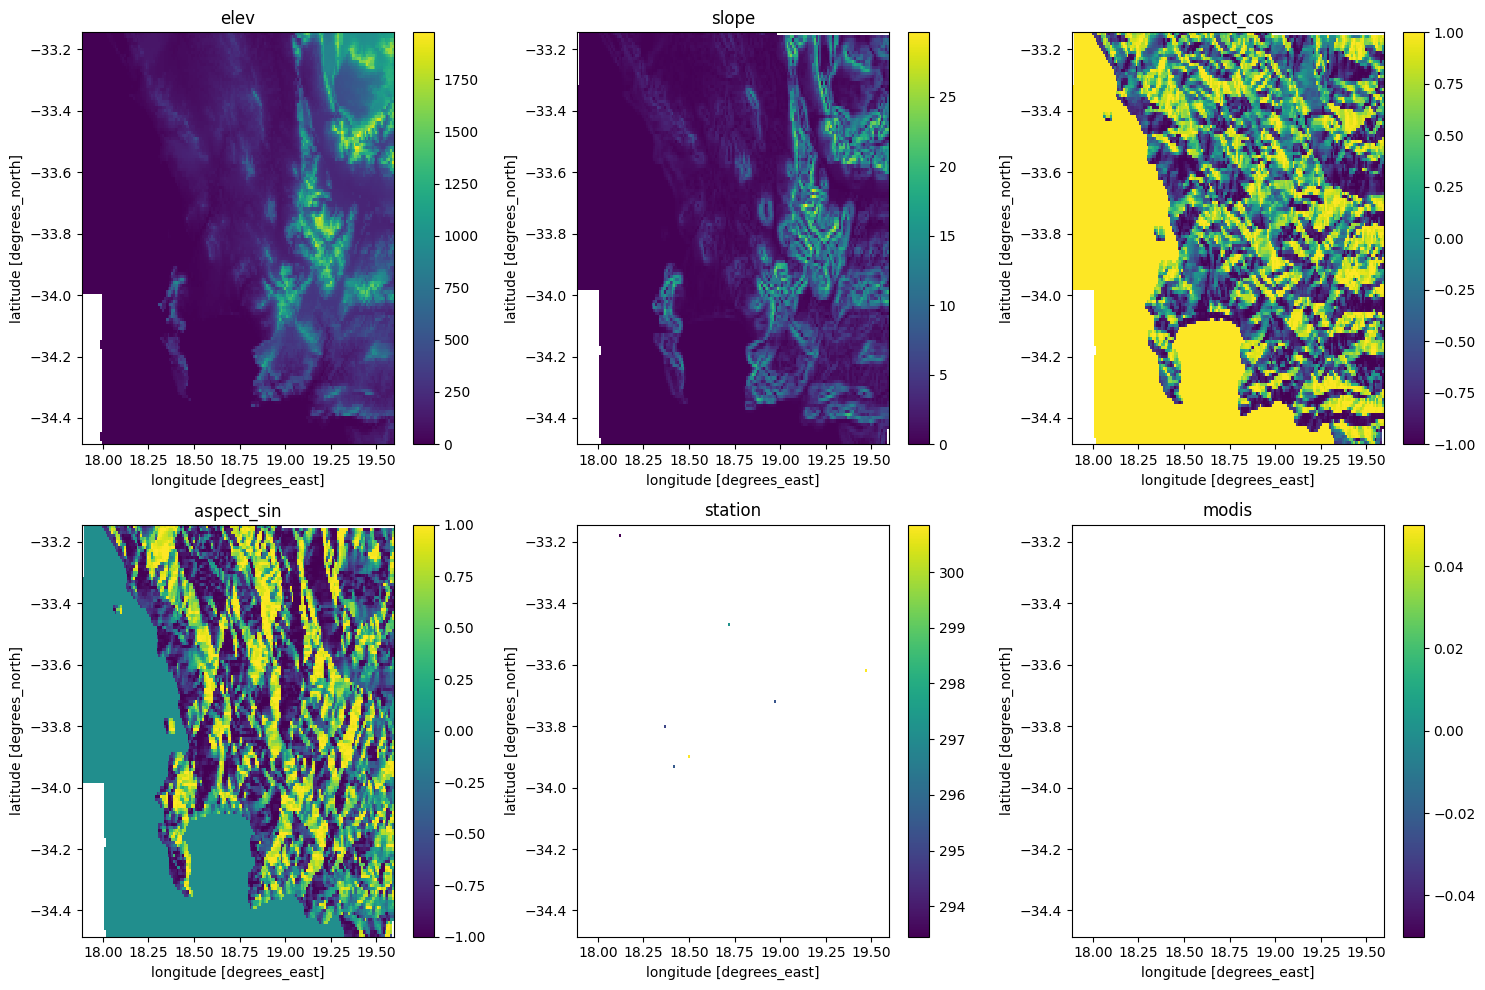

In [46]:
# Select a single time slice and channel
time_slice = da_stacked_channels.isel(time=1000)  # Select a specific time
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot each channel
for i, chan in enumerate(da_stacked_channels.dataset.values):
    if i >= len(axes):
        break
    time_slice.sel(dataset=chan).plot(ax=axes[i], cmap='viridis')
    axes[i].set_title(f'{chan}')

plt.tight_layout()
plt.show()

# Baseline RF

y = LST - merged stations and MODIS data


    * 0.  LST (combined MODIS + STATION) for now use the mean - use only stations that are (almost) always present
    * 1.  Calculate LST_station.mean(dim=[‘x’, ‘y’]) - will be a time series and add to our Dataset
    * 2.  Convert dataset to DataFrame
    * Y = LST 
    * X = other variables [elevation, slope, aspect, spatial mean station LST]



#### 0:

In [61]:
da_lst

<xarray.DataArray 'lst' (dataset: 2, time: 2983, y: 134, x: 171)> Size: 1GB
dask.array<rechunk-merge, shape=(2, 2983, 134, 171), dtype=float64, chunksize=(1, 31, 80, 80), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59
  * time     (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17
  * dataset  (dataset) <U7 56B 'station' 'modis'

In [62]:
# option 1:
lst_combined = da_lst.mean(dim='dataset')
lst_combined

<xarray.DataArray 'lst' (time: 2983, y: 134, x: 171)> Size: 547MB
dask.array<mean_agg-aggregate, shape=(2983, 134, 171), dtype=float64, chunksize=(31, 80, 80), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59
  * time     (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17

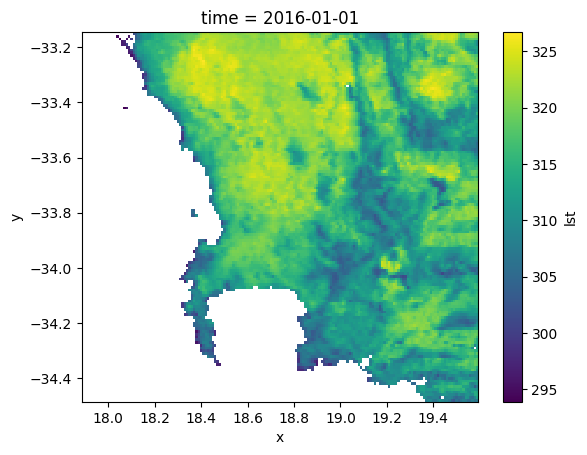

In [65]:
lst_combined[0,:,:].plot();

In [ ]:
# Alternatively:

# First average the LST data
lst_combined_ = da_lst.mean(dim='dataset')

# Now expand dimensions to make it compatible for concatenation
lst_combined_expanded_ = lst_combined.expand_dims(dataset=['lst_combined'])

# Stack with other variables
da_stacked_channels_ = xr.concat([
    dem[['elev', 'slope', 'aspect_cos', 'aspect_sin']].to_array(dim='dataset'),
    lst_combined_expanded_
], dim='dataset').transpose('time', 'dataset', 'y', 'x')

In [76]:
combined_lst_ = da_stacked_channels_.sel(dataset='lst_combined')


#### 1:

In [65]:
da_lst

<xarray.DataArray 'station_LST' (dataset: 2, time: 2983, y: 134, x: 171)> Size: 1GB
dask.array<concatenate, shape=(2, 2983, 134, 171), dtype=float64, chunksize=(1, 1, 34, 43), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1kB -33.15 -33.16 -33.17 ... -34.46 -34.47 -34.48
  * x        (x) float64 1kB 17.89 17.9 17.91 17.92 ... 19.56 19.57 19.58 19.59
  * time     (time) datetime64[s] 24kB 2016-01-01 2016-01-02 ... 2024-03-17
Dimensions without coordinates: dataset

In [35]:
len(da_lst['time'].values)

2983

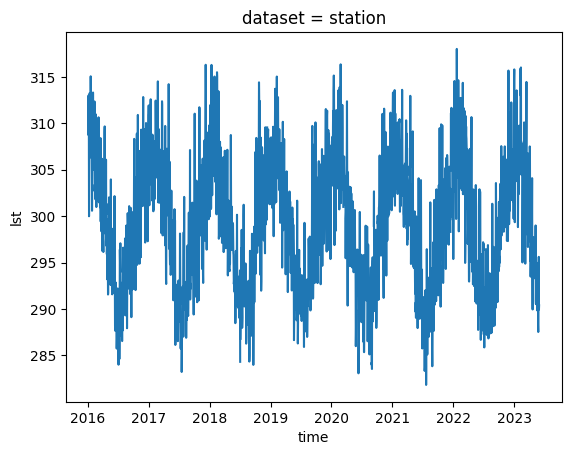

In [74]:
# 2. Calculate the spatial mean (average across all locations)

lst_station = da_lst.sel(dataset='station')

lst_station_spatial_mean = lst_station.mean(dim=['x', 'y'])
lst_station_spatial_mean.plot()

In [ ]:
ds = xr.Dataset()

# Add the spatial mean as a variable
ds['lst_station_mean'] = lst_station_spatial_mean

ds['lst_combined'] = lst_combined

# For features from the DEM
for feature in ['elev', 'slope', 'aspect_cos', 'aspect_sin']:
    ds[feature] = da_stacked_channels.sel(dataset=feature)


In [77]:
ds = ds.drop_vars(["platform", "gsd", "epsg", "proj:code", "proj:shape", "spatial_ref", "dataset"])
ds

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 2983, y: 134, x: 171)
Coordinates:
  * time              (time) datetime64[s] 24kB 2016-01-01 ... 2024-03-17
  * y                 (y) float64 1kB -33.15 -33.16 -33.17 ... -34.47 -34.48
  * x                 (x) float64 1kB 17.89 17.9 17.91 ... 19.57 19.58 19.59
Data variables:
    lst_station_mean  (time) float64 24kB dask.array<chunksize=(31,), meta=np.ndarray>
    lst_combined      (time, y, x) float64 547MB dask.array<chunksize=(31, 80, 80), meta=np.ndarray>
    elev              (time, y, x) float64 547MB dask.array<chunksize=(31, 80, 80), meta=np.ndarray>
    slope             (time, y, x) float64 547MB dask.array<chunksize=(31, 80, 80), meta=np.ndarray>
    aspect_cos        (time, y, x) float64 547MB dask.array<chunksize=(31, 80, 80), meta=np.ndarray>
    aspect_sin        (time, y, x) float64 547MB dask.array<chunksize=(31, 80, 80), meta=np.ndarray>

In [79]:
df_dask = ds.unify_chunks().to_dask_dataframe()
df_dask

,time,y,x,lst_station_mean,lst_combined,elev,slope,aspect_cos,aspect_sin
npartitions=677,,,,,,,,,
0,datetime64[s],float64,float64,float64,float64,float64,float64,float64,float64
114570,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
68306634,...,...,...,...,...,...,...,...,...
68352461,...,...,...,...,...,...,...,...,...


In [80]:
df = ds.to_dataframe()
df.to_parquet("../data/RF_dataset.parquet")

In [81]:
load_df = pd.read_parquet("../data/RF_dataset.parquet")

In [82]:
load_df.shape

(68352462, 6)

In [28]:
ds_stacked = ds.stack(location=['y', 'x'])

# 2. Convert to DataFrame
df = ds_stacked.to_dataframe()

In [30]:
df.shape

(68352462, 15)

In [37]:
check = df.dropna(subset=['lst_combined'])

In [39]:
check.isnull().sum()

dataset                   0
lst_station_mean    1241900
lst_combined              0
platform                  0
gsd                       0
epsg                      0
proj:code                 0
proj:shape                0
spatial_ref               0
elev                      0
slope                 62282
aspect_cos            62282
aspect_sin            62282
y                         0
x                         0
dtype: int64

In [40]:
check.shape

(12663143, 15)